In [1]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random

In [2]:
p_train = 0.01
p_test = 0.05

###############################
# THIS ONLY NEEDS TO RUN ONCE #
###############################

indexes = random.sample(range(1,68853600),int(68853600*(1-p_train)))

#LOADING TRAINING SET
start = time.time()

#Loading the inputs for the training set
train_inputs_thermal = pd.read_csv('..\\data2\\inputs\\inputs_thermal.csv')
input_vars = list(test_inputs_thermal.columns[1:])
X = np.array(train_inputs_thermal.loc[:,'G_Dh':].values)
area_envelope = np.multiply(np.array(train_inputs_thermal.loc[:,'perimeter'].values),np.array(train_inputs_thermal.loc[:,'height'].values)) + 2*np.array(train_inputs_thermal.loc[:,'area'].values)
train_inputs_thermal = None

#Loading the outputs or targets for the training set
train_outputs_thermal = pd.read_csv('..\\data2\\energy_demands\\thermal_losses.csv')
Y = np.array(train_outputs_thermal.loc[:,'Qs-Qi(Wh)'].values)
train_outputs_thermal = None

end = time.time()
print(str(end-start)+' seconds')

#SCALING TRAINING SET
start = time.time()

#Scaling the inputs and outputs (substracting mean and dividing by the standard deviation)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = np.divide(X - X_mean, X_std)

#We use the area of the building enevelope to normalize the thermal losses (since we know that thermal losses are proportional to this area)
Y = np.divide(Y, area_envelope)
area_envelope = None
Y_mean = Y.mean(axis=0)
Y_std = Y.std(axis=0)
Y = np.divide(Y - Y_mean, Y_std)

end = time.time()
print(str(end-start)+' seconds')

#LOADING THE TEST SET
start = time.time()

indexes = random.sample(range(1,12299040),int(12299040*(1-p_test)))

test_inputs_thermal = pd.read_csv('..\\data2\\inputs\\inputs_thermal_testset.csv')
X_test = np.array(test_inputs_thermal.loc[:,'G_Dh':].values)
area_envelope_test = np.multiply(np.array(test_inputs_thermal.loc[:,'perimeter'].values),np.array(test_inputs_thermal.loc[:,'height'].values)) + 2*np.array(test_inputs_thermal.loc[:,'area'].values)
test_inputs_thermal = None

test_outputs_thermal = pd.read_csv('..\\data2\\energy_demands\\thermal_losses_testset.csv')
Y_test = np.array(test_outputs_thermal.loc[:,'Qs-Qi(Wh)'].values)
test_outputs_thermal = None

end = time.time()
print(str(end-start)+' seconds')

#SCALING TEST SET
X_test = np.divide(X_test - X_mean, X_std)

250.86923599243164 seconds
26.125606536865234 seconds
61.280197858810425 seconds


In [3]:
##################################
# THIS IS THE CODE TO BE CHANGED #
##################################

start = time.time()

#TRAINING THE MACHINE LEARNING REGRESSOR
regr = RandomForestRegressor(max_depth=8, n_estimators=30)
regr.fit(X, Y) 

end = time.time()
train_time = end-start
print(str(train_time)+' seconds')

14009.937567472458 seconds


In [35]:
#We print the importances of the features we used for learning based on the information gain due to each of them (not all the regression algorithms allow this).
j = 0
for i in input_vars:
    print(str(i)+': '+str(round(regr.feature_importances_[j]*100,2))+'%')
    j += 1

G_Dh: 0.03%
G_Bn: 2.07%
RR: 0.0%
N: 0.0%
 Ta: 83.81%
 FF: 0.0%
 RH: 0.02%
height: 1.6%
perimeter: 0.0%
aspect_ratio: 0.0%
walls_glazing_ratio: 2.91%
urban_area_index: 0.01%
latitude: 1.01%
longitude: 0.02%
elevation: 0.02%
ground_sw_reflectance: 0.0%
area: 0.26%
t_sp: 6.02%
n_inf: 0.41%
walls_uvalue: 0.1%
floor_uvalue: 0.89%
roof_uvalue: 0.0%
windows_uvalue: 0.82%
walls_sw_reflectance: 0.0%
roof_sw_reflectance: 0.0%


In [5]:
start = time.time()

#TESTING THE MACHINE LEARNING REGRESSOR
Y_pred = regr.predict(X_test)

end = time.time()
test_time = end-start

#Y_pred is normalized (since the regressor was trained using normalized targets). Now we de-normalize it a de-scale the predictions.
Y_pred = np.multiply(np.multiply(Y_pred, Y_std) + Y_mean, area_envelope_test)

print(str(test_time)+' seconds')

13.982409477233887 seconds


In [6]:
#Calculating scores 0.6562254167979638
r2 = r2_score(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
mae = mean_absolute_error(Y_test,Y_pred)

In [7]:
#Displaying results
print('Results for THERMAL LOSSES:')
print('R2: '+str(r2))
print('mse: '+str(mse))
print('mae: '+str(mae))
print('train_time: '+str(train_time))
print('test_time: '+str(test_time))

Results for THERMAL LOSSES:
R2: 0.8415276605244258
mse: 3034304130.6991296
mae: 21173.885076729355
train_time: 14009.937567472458
test_time: 13.982409477233887


Text(0, 0.5, 'Thermal losses (Wh)')

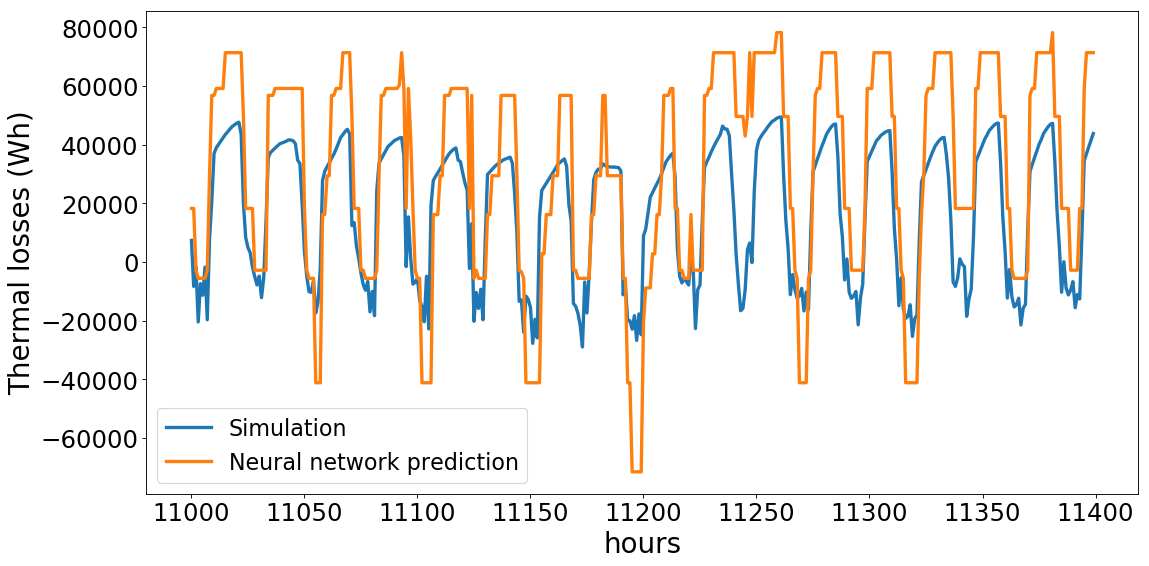

In [8]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22)
plt.plot(list(range(11000,11400)), Y_test[11000:11400],linewidth=3.0)
plt.plot(list(range(11000,11400)), Y_pred[11000:11400],linewidth=3.0)
plt.legend(['Simulation','Neural network prediction'], fontsize=20)
plt.xlabel('hours', fontsize=25)
plt.ylabel('Thermal losses (Wh)', fontsize=25)

# plt.savefig('thermal_losses.png', dpi=600)